In [99]:
import os
import shutil
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image

In [100]:
# You first need to set you directory structure
# and collect the behavioral files for the localizer and the
# study task separately.  Given that each task will be modeled
# separately treat them separately.

proj_dir = "/home/sjsuss626/Mattfeld_PSB6351/"

task_loc = sorted(glob(proj_dir + 'behav/*loc*.tsv'))
task_study = sorted(glob(proj_dir + 'behav/*study*.tsv'))

# use os.path.join or Pathlib to define location of files
# use glob and sort to grab relevant files...I would separately handle localizer and task .tsv files

In [101]:
# Ensure 'trial_type' exists as a column
loc_run1 = task_loc[0]
loc_run1_df = pd.read_csv(loc_run1, sep='\t')  # Read the file with the original column names

import pandas as pd

# Assuming loc_run1_df is your main DataFrame
# Add a 'block_id' column to identify unique blocks
loc_run1_df['block_id'] = (loc_run1_df['trial_type'] != loc_run1_df['trial_type'].shift()).cumsum()

# Create unique DataFrames for each block
for block_id, group in loc_run1_df.groupby('block_id'):
    # Dynamically create variable names for each block DataFrame
    globals()[f"block_{block_id}"] = group.drop(columns=['block_id']) 
    #print(f"DataFrame for Block {block_id} (Trial Type: {group['trial_type'].iloc[0]}) created.")
    #print(eval(f"block_{block_id}").head())  
    #print("---")


# Define a function to calculate ISI for any block
def calculate_isi(block, trial_duration=0.5):
    num_trials = len(block)
    time_presentation = trial_duration * num_trials
    # Use .iloc for positional indexing
    total_block_time = block.iloc[num_trials - 1]['onset'] - block.iloc[0]['onset']
    isi = (total_block_time - time_presentation) / (num_trials - 1)
    return isi

# ISI for block_1 (face)
isi_face = calculate_isi(block_1)
print(f"ISI for 'face' block: {isi_face}")

# ISI for block_2 (math)
isi_math = calculate_isi(block_2)
print(f"ISI for 'math' block: {isi_math}")

# ISI for block_3 (scene)
isi_scene = calculate_isi(block_3)
print(f"ISI for 'scene' block: {isi_scene}")

ISI for 'face' block: 0.7231878512047369
ISI for 'math' block: 0.6944599352999998
ISI for 'scene' block: 0.7231680044210527


In [102]:
# Define the base project directory and the EV directory paths for FSL and AFNI
fsl_ev_dir = os.path.join(proj_dir, 'derivatives', 'task_evs', 'fsl_ev_files')
afni_ev_dir = os.path.join(proj_dir, 'derivatives', 'task_evs', 'afni_ev_files')

# Create the EV directories if they do not exist
os.makedirs(fsl_ev_dir, exist_ok=True)
os.makedirs(afni_ev_dir, exist_ok=True)

In [103]:
#Creating LOC EV files

# Initialize a dictionary to store AFNI data across runs
afni_data = {}

# Iterate over each task_loc file
for file_path in task_loc:
    # Load the TSV file into a DataFrame
    loc_df = pd.read_csv(file_path, sep='\t')

    # Select relevant columns and ensure 'trial_type' is included for filtering
    loc_df = loc_df[['onset', 'duration', 'trial_type']]

    # List of unique conditions in the current file
    conditions = loc_df['trial_type'].unique()
    
    # Group by 'trial_type'
    grouped = loc_df.groupby('trial_type')

    # Iterate over each condition and create separate DataFrames
    for condition in conditions:
        try:
            condition_df = grouped.get_group(condition)

            # Add 'amplitude' column for FSL files
            condition_df.loc[:, 'amplitude'] = 1
            fsl_condition_df = condition_df[['onset', 'duration', 'amplitude']]

            # Save FSL EV file
            fsl_output_filename = f"{fsl_ev_dir}/{os.path.basename(file_path).replace('.tsv', f'_{condition}.txt')}"
            fsl_condition_df.to_csv(fsl_output_filename, sep=' ', index=False, header=False)

            # Prepare AFNI 1D file: Create 'onset:duration' format for each row
            afni_condition_df = condition_df[['onset', 'duration']]
            afni_condition_df['afni_format'] = afni_condition_df.apply(lambda x: f"{x['onset']}:{x['duration']}", axis=1)

            # Aggregate rows for each condition across runs
            if condition not in afni_data:
                afni_data[condition] = []  
            afni_data[condition].append(" ".join(afni_condition_df['afni_format'].tolist()))

        except KeyError as e:
            print(f"Condition {condition} not found in {file_path}")
            continue

# Export stacked rows for AFNI 1D files
for condition, data in afni_data.items():
    afni_output_filename = os.path.join(afni_ev_dir, f'loc_{condition}_evs.1D')
    with open(afni_output_filename, 'w') as afni_file:
        afni_file.write("\n".join(data)) 


/tmp/ipykernel_98109/2760495122.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_df.loc[:, 'amplitude'] = 1
/tmp/ipykernel_98109/2760495122.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afni_condition_df['afni_format'] = afni_condition_df.apply(lambda x: f"{x['onset']}:{x['duration']}", axis=1)
/tmp/ipykernel_98109/2760495122.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [104]:
#Creating Task EV files

# Initialize dictionaries to store AFNI data (each condition has a list of runs)
afni_data = {
    "faces": [],
    "scenes": [],
    "baseline": [],
    "conditional": [],
    "faces_before_COND": [],
    "faces_before_baseline": [],
    "scenes_before_COND": [],
    "scenes_before_baseline": [],
    "faces_before_COND_correct": [],
    "faces_before_COND_incorrect": [],
    "scenes_before_COND_correct": [],
    "scenes_before_COND_incorrect": []
}

# Iterate over each task_study file
for file_path in task_study:
    # Load the TSV file into a DataFrame
    study_df = pd.read_csv(file_path, sep='\t')

    # Initialize a sublist for this run for each condition
    for key in afni_data.keys():
        afni_data[key].append([])  

    # Select relevant columns
    study_df = study_df[['onset', 'trial_type', 'acc']]

    # Map trial types to combined conditions
    trial_type_map = {
        "face1": "faces",
        "face2": "faces",
        "scene1": "scenes",
        "scene2": "scenes",
        "baseline": "baseline",
        "COND": "conditional"
    }

    # Add a column for combined conditions
    study_df['combined_condition'] = study_df['trial_type'].map(trial_type_map)

    # Group by combined_condition
    grouped = study_df.groupby('combined_condition')

    # Process combined conditions (original conditions)
    for combined_condition, condition_df in grouped:
        afni_data[combined_condition][-1].extend(condition_df['onset'].tolist())  

    # Process new conditions based on preceding trials
    for i in range(1, len(study_df)):
        current_row = study_df.iloc[i]
        previous_row = study_df.iloc[i - 1]

        # Check if the current trial is `COND` or `baseline`
        if current_row['trial_type'] == "COND":
            if previous_row['trial_type'] in ["face1", "face2"]:
                afni_data["faces_before_COND"][-1].append(previous_row['onset'])
                if previous_row['acc'] == 1.0:  # Correct
                    afni_data["faces_before_COND_correct"][-1].append(previous_row['onset'])
                elif previous_row['acc'] == 0.0:  # Incorrect
                    afni_data["faces_before_COND_incorrect"][-1].append(previous_row['onset'])
            elif previous_row['trial_type'] in ["scene1", "scene2"]:
                afni_data["scenes_before_COND"][-1].append(previous_row['onset'])
                if previous_row['acc'] == 1.0:  # Correct
                    afni_data["scenes_before_COND_correct"][-1].append(previous_row['onset'])
                elif previous_row['acc'] == 0.0:  # Incorrect
                    afni_data["scenes_before_COND_incorrect"][-1].append(previous_row['onset'])
        elif current_row['trial_type'] == "baseline":
            if previous_row['trial_type'] in ["face1", "face2"]:
                afni_data["faces_before_baseline"][-1].append(previous_row['onset'])
            elif previous_row['trial_type'] in ["scene1", "scene2"]:
                afni_data["scenes_before_baseline"][-1].append(previous_row['onset'])

# Combine onset times for each condition and export AFNI 1D files
for condition, runs in afni_data.items():
    afni_output_filename = os.path.join(afni_ev_dir, f'{condition}_evs.1D')

    with open(afni_output_filename, 'w') as afni_file:
        for run in runs:  
            if not run:  
                afni_file.write("-1\n")  # Write -1 for empty runs
            else:
                afni_file.write(" ".join(map(str, run)) + "\n")  
    print(f"Saved AFNI 1D file for condition '{condition}': {afni_output_filename}")


Saved AFNI 1D file for condition 'faces': /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/faces_evs.1D
Saved AFNI 1D file for condition 'scenes': /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/scenes_evs.1D
Saved AFNI 1D file for condition 'baseline': /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/baseline_evs.1D
Saved AFNI 1D file for condition 'conditional': /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/conditional_evs.1D
Saved AFNI 1D file for condition 'faces_before_COND': /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/faces_before_COND_evs.1D
Saved AFNI 1D file for condition 'faces_before_baseline': /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/faces_before_baseline_evs.1D
Saved AFNI 1D file for condition 'scenes_before_COND': /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/scenes_before_COND_evs.1D
Saved AFNI 1D file for condition 'sce

In [105]:
# This cell is required to run the following 3dDeconvolve calls in the subsequent cells
# Here I am collecting the motion related regressor files that were created for each run
# separately, concatenating them and saving the output.

# the below directory structure will change to match how your data are organized
proj_dir = '/home/sjsuss626/Mattfeld_PSB6351/'
motion_dir = '/derivatives/preproc_motion_first/sub-021/motion'

loc_motion_files = sorted(glob(proj_dir + motion_dir + '/_volreg*/*loc*bold.1D'))
loc_mot_dict = {}
for mot_i, curr_loc_motion_file in enumerate(loc_motion_files):
    loc_mot_dict[f'run{mot_i + 1}'] = np.genfromtxt(curr_loc_motion_file)
    
allruns_loc_motion_data = np.concatenate((loc_mot_dict['run1'], loc_mot_dict['run2']))
np.savetxt(proj_dir + motion_dir + '/allruns_loc_mot_data.1D', allruns_loc_motion_data)

task_motion_files = sorted(glob(proj_dir + motion_dir + '/_volreg*/*study*bold.1D'))
task_mot_dict = {}
for mot_i, curr_task_motion_file in enumerate(task_motion_files):
    task_mot_dict[f'run{mot_i + 1}'] = np.genfromtxt(curr_task_motion_file)
    
allruns_task_motion_data = np.concatenate((task_mot_dict['run1'], task_mot_dict['run2'],
                                           task_mot_dict['run3'], task_mot_dict['run4']))
np.savetxt(proj_dir + motion_dir + '/allruns_task_mot_data.1D', allruns_task_motion_data)

Below, I need the face, scene, and math conditions to create my ROIs. I will uses the math as contrast agains face and scene condition and threshold actvation values to determine my ROIs. 

In [106]:
%%bash
# Given that we are running this with no data (see -nodata flag) we can run a quick bash
# command in the cell by using line above.  The matrices that are created and image
# will be created in the directory where this jupyter notebook is running. In my case.
# /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/code

3dDeconvolve -nodata 608 1.76 \
-concat '1D: 0 304' \
-ortvec /home/sjsuss626/Mattfeld_PSB6351/derivatives/preproc_motion_first/sub-021/motion/allruns_loc_mot_data.1D motion \
-polort A \
-local_times \
-num_stimts 3 \
-stim_times_AM1 1 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/loc_face_evs.1D "dmBLOCK(1)" -stim_label 1 faces \
-stim_times_AM1 2 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/loc_scence_evs.1D "dmBLOCK(1)" -stim_label 2 scenes \
-stim_times_AM1 3 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/loc_math_evs.1D "dmBLOCK(1)" -stim_label 2 math \
-x1D X.loc.xmat.1D -xjpeg X.loc.jpg

++ '-stim_times_AM1 1 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/loc_face_evs.1D' has 1 auxiliary values per time point
++ '-stim_times_AM1 1': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/loc_face_evs.1D'
++ '-stim_times_AM1 2 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/loc_scence_evs.1D' has 1 auxiliary values per time point
++ '-stim_times_AM1 2': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/loc_scence_evs.1D'
++ '-stim_times_AM1 3 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/loc_math_evs.1D' has 1 auxiliary values per time point
++ '-stim_times_AM1 3': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/sjsuss626/Mattfeld_PSB6351/derivative


Stimulus: faces 
  h[ 0] norm. std. dev. =   0.0985

Stimulus: math 
  h[ 0] norm. std. dev. =   0.1017

Stimulus: Stim#3 
  h[ 0] norm. std. dev. =   0.1011

Stimulus: motion[0] 
  h[ 0] norm. std. dev. =   1.8386

Stimulus: motion[1] 
  h[ 0] norm. std. dev. =   1.0892

Stimulus: motion[2] 
  h[ 0] norm. std. dev. =   1.4237

Stimulus: motion[3] 
  h[ 0] norm. std. dev. =   0.5034

Stimulus: motion[4] 
  h[ 0] norm. std. dev. =   1.7536

Stimulus: motion[5] 
  h[ 0] norm. std. dev. =   0.3546


I am setting up my matrix below so I can see the effect correct vs incorrect trails acrosss both the face and scene conditions. I expect accracy trials in be associated with greater activaton in localized regions of that condition. I amd modeling baseline and condtional conditions out seperately here, but they could be collaposed as they are not important to my question. 

In [ ]:
%%bash

3dDeconvolve -nodata 1420 1.76 \
-concat '1D: 0 355 710 1065' \
-ortvec /home/sjsuss626/Mattfeld_PSB6351/derivatives/preproc_motion_first/sub-021/motion/allruns_task_mot_data.1D motion \
-polort A \
-local_times \
-num_stimts 8 \
-stim_times 1 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/faces_before_COND_correct_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 1 face_b4_c_cond \
-stim_times 2 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/faces_before_COND_incorrect_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 2 face_b4_ic_cond \
-stim_times 3 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/scenes_before_COND_correct_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 1 scene_b4_c_cond \
-stim_times 4 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/scenes_before_COND_incorrect_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 2 scene_b4_ic_cond \
-stim_times 5 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/conditional_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 3 conditional \
-stim_times 6 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/baseline_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 4 baseline \
-stim_times 7 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/faces_before_baseline_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 4 facefx_b4_bl \
-stim_times 8 /home/sjsuss626/Mattfeld_PSB6351/derivatives/task_evs/afni_ev_files/scenes_before_baseline_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 5 scenefx_b4_bl \
-x1D X.task.xmat.1D -xjpeg X.task.jpg


++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
*+ WARNING: -stim_label 1 'scene_b4_c_cond' replacing old label 'face_b4_c_cond'
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
*+ WARNING: -stim_label 2 'scene_b4_ic_cond' replacing old label 'face_b4_ic_cond'
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346


++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
*+ WARNING: -stim_label 4 'facefx_b4_bl' replacing old label 'baselinel'
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ 3dDeconvolve extending num_stimts from 8 to 14 due to -ortvec
*+ WARNING: no -stim_label given for stim #6 ==> label = 'Stim#6'
*+ WARNING: no -stim_label given for stim #7 ==> label = 'Stim#7'
*+ WARNING: no -stim_label given for stim #8 ==> label = 'Stim#8'
++ 3dDeconvolve: AFNI version=AFNI_24.0.10 (Mar  5 2024) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.76 seconds for -stim_times and -nodata
++ using NT=1420 time points for -nodata
++ Imaging duration=624.8 s; Automatic polort=5
++ -stim_times u


Stimulus: scene_b4_c_cond 
  h[ 0] norm. std. dev. =   0.1280

Stimulus: scene_b4_ic_cond 
  h[ 0] norm. std. dev. =   0.2380

Stimulus: conditional 
  h[ 0] norm. std. dev. =   0.1255

Stimulus: facefx_b4_bl 
  h[ 0] norm. std. dev. =   0.2181

Stimulus: scenefx_b4_bl 
  h[ 0] norm. std. dev. =   0.0931

Stimulus: Stim#6 
  h[ 0] norm. std. dev. =   0.1260

Stimulus: Stim#7 
  h[ 0] norm. std. dev. =   0.1279

Stimulus: Stim#8 
  h[ 0] norm. std. dev. =   0.1275

Stimulus: motion[0] 
  h[ 0] norm. std. dev. =   1.2096

Stimulus: motion[1] 
  h[ 0] norm. std. dev. =   0.8962

Stimulus: motion[2] 
  h[ 0] norm. std. dev. =   0.8171

Stimulus: motion[3] 
  h[ 0] norm. std. dev. =   0.5289

Stimulus: motion[4] 
  h[ 0] norm. std. dev. =   1.0848

Stimulus: motion[5] 
  h[ 0] norm. std. dev. =   0.2547


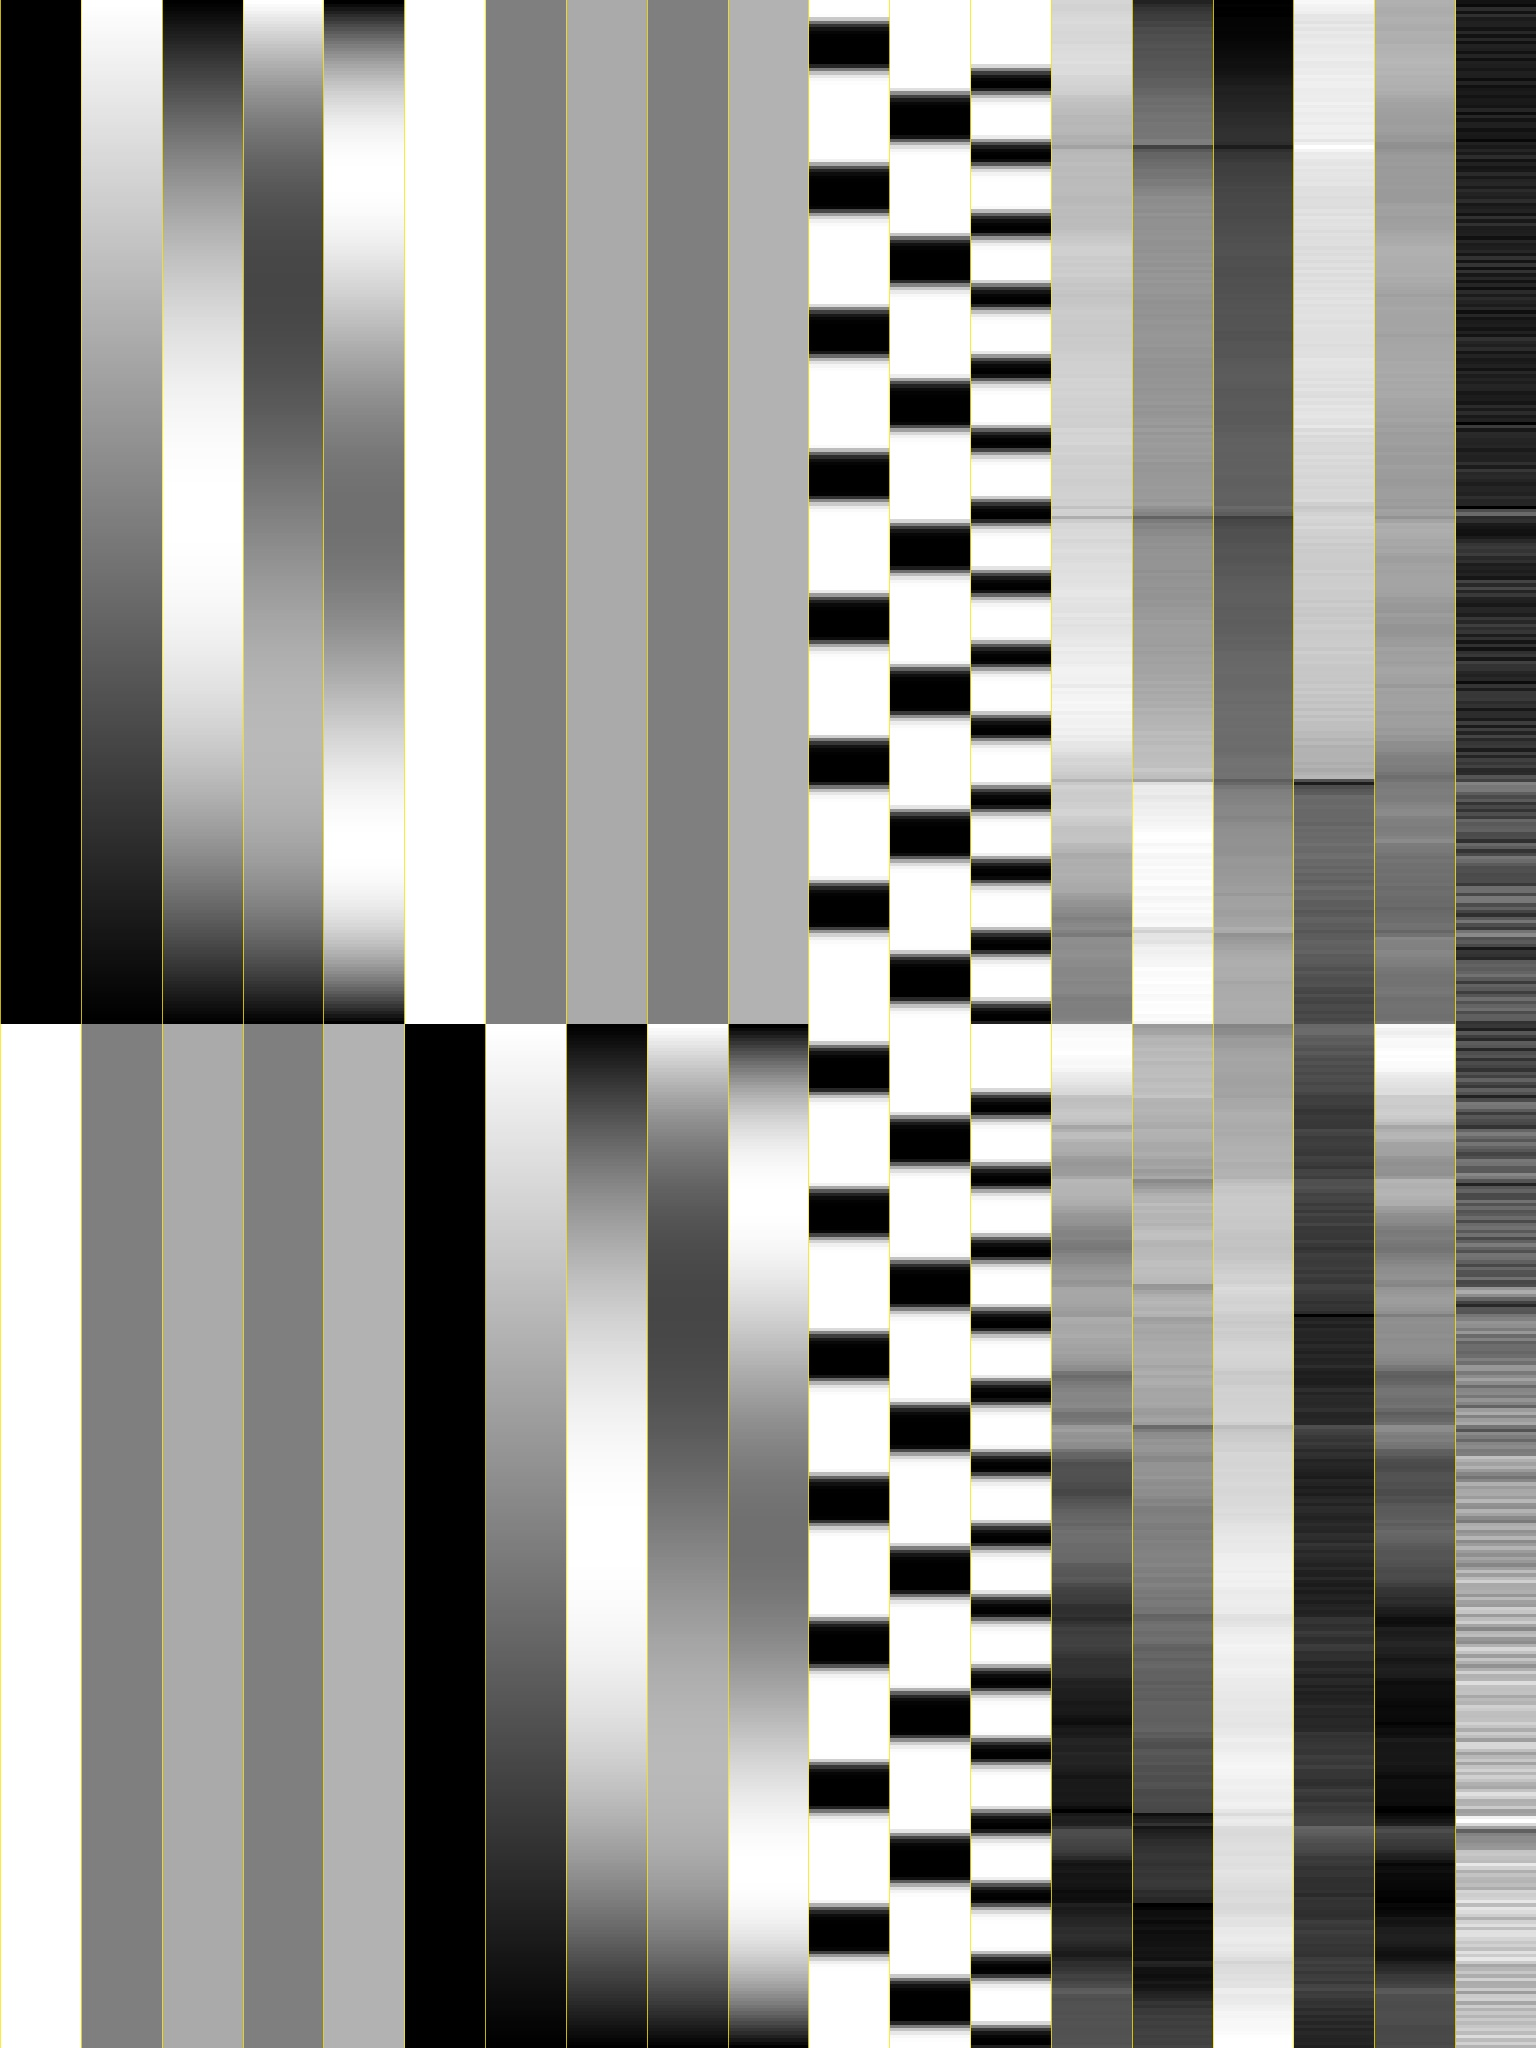

In [108]:
im_loc = Image.open(os.path.join(os.getcwd(), 'X.loc.jpg'))
im_loc

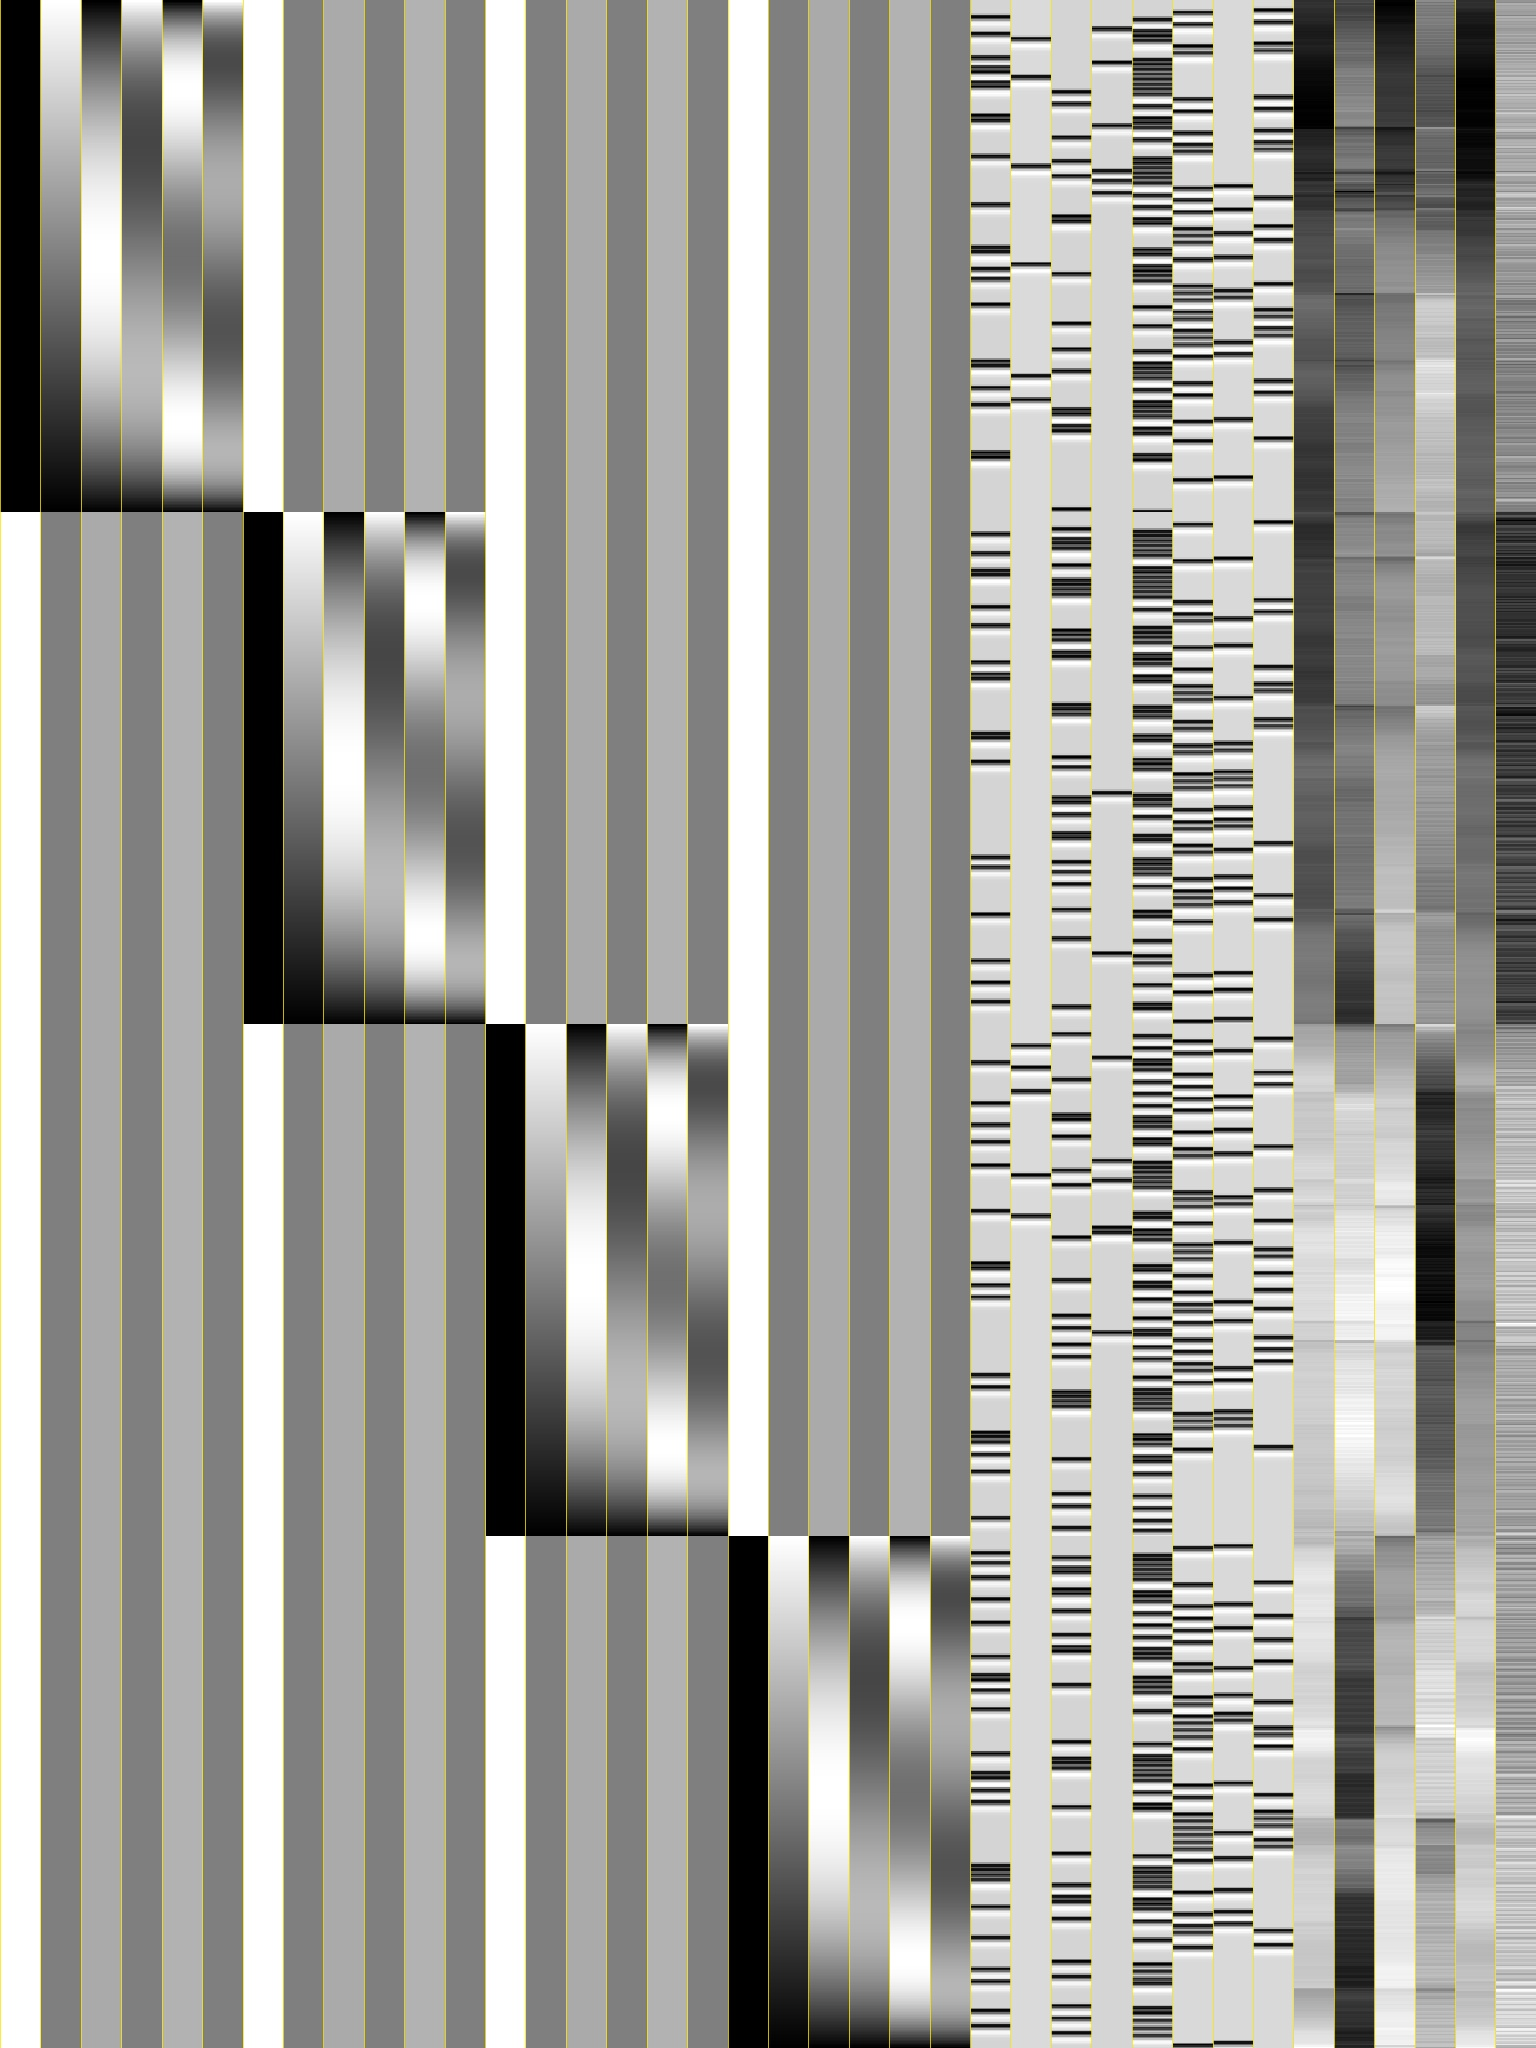

In [109]:
im_task = Image.open(os.path.join(os.getcwd(), 'X.task.jpg'))
im_task